# Word Embeddings

## Let's train a simple Word2Vec model

In [75]:
!sudo apt update && sudo apt install -y gcc g++

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease3m
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [99]:
!pip install gensim sklearn bs4 pandas matplotlib fasttext pandas

In [77]:
from IPython.display import display
import pandas

lines = []
with open("data.txt") as f:
    lines = [line.split("\t")[1] for line in f.readlines()]
pandas.DataFrame(lines[:3], columns=["line"])

,line
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...\n
2,Free entry in 2 a wkly comp to win FA Cup fina...


Tokenize the lines

In [78]:
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, preprocess_documents


sentences = preprocess_documents(lines)
pandas.DataFrame(zip(lines[:3], sentences[:3]), columns=["line", "tokens"])

,line,tokens
0,"Go until jurong point, crazy.. Available only ...","[jurong, point, crazi, avail, bugi, great, wor..."
1,Ok lar... Joking wif u oni...\n,"[lar, joke, wif, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entri, wkly, comp, win, cup, final, tkt..."


Train the model

In [79]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=sentences, min_count=2)

What does the vocabulary look like?

In [80]:
pandas.DataFrame(w2v_model.wv.index_to_key[:5], columns=["term"])

,term
0,come
1,dai
2,free
3,know
4,love


Let's see some similarities

In [81]:
from gensim.parsing.preprocessing import preprocess_string

pandas.DataFrame(w2v_model.wv.most_similar(preprocess_string("nokia"), topn=10), columns=["term", "similarity"])

,term,similarity
0,txt,0.999484
1,week,0.999467
2,mobil,0.999453
3,free,0.999399
4,tone,0.999377
5,repli,0.999301
6,www,0.999225
7,text,0.999203
8,com,0.999185
9,msg,0.999160


Word2Vec cannot handle unknown words

In [82]:
try:
    w2v_model.wv.similar_by_word("blubbergurken")
except KeyError as e:
    display(e)

KeyError("Key 'blubbergurken' not present")

## fastText

In [83]:
from gensim.models import FastText
from gensim.utils import tokenize
from gensim.parsing.preprocessing import preprocess_string
ft_model = FastText()
corpus = [list(tokenize(line, lowercase=True, deacc=True)) for line in lines]
ft_model.build_vocab(corpus_iterable=corpus)
ft_model.train(corpus_iterable=corpus, total_examples=len(corpus), epochs=100)

(5911818, 8762900)

In [84]:
pandas.DataFrame(ft_model.wv.most_similar("nokia", topn=10), columns=["term", "similarity"])

,term,similarity
0,motorola,0.513203
1,colour,0.486458
2,video,0.483614
3,loyalty,0.483218
4,spook,0.472866
5,camera,0.470270
6,latest,0.470068
7,gb,0.465346
8,mobiles,0.461243
9,mob,0.456654


## Can also be used for classification

In [85]:
with open("data.txt") as f:
    lines = [next(f) for line in range(5)]
pandas.DataFrame(lines, columns=["line"])

,line
0,"__label__ham\tGo until jurong point, crazy.. A..."
1,__label__ham\tOk lar... Joking wif u oni...\n
2,__label__spam\tFree entry in 2 a wkly comp to ...
3,__label__ham\tU dun say so early hor... U c al...
4,__label__ham\tNah I don't think he goes to usf...


In [86]:
import fasttext

model = fasttext.train_supervised("data.txt")

In [87]:
model.test("data.txt")

(5574, 0.9921062073914604, 0.9921062073914604)

In [88]:
prediction = model.predict("Congratulations YOU'VE Won. You're a Winner in our August £1000 Prize Draw. Call 09066660100 NOW. Prize Code 2309.")
pandas.DataFrame([[x[0] for x in prediction]], columns=["label", "confidence"])

,label,confidence
0,__label__spam,0.890247


## A more complex model

Gensim provides a lot of pretrained models

In [89]:
import gensim.downloader
pandas.DataFrame(list(gensim.downloader.info()['models'].keys()), columns=["model"])

,model
0,fasttext-wiki-news-subwords-300
1,conceptnet-numberbatch-17-06-300
2,word2vec-ruscorpora-300
3,word2vec-google-news-300
4,glove-wiki-gigaword-50
5,glove-wiki-gigaword-100
6,glove-wiki-gigaword-200
7,glove-wiki-gigaword-300
8,glove-twitter-25
9,glove-twitter-50


In [90]:
wiki_model = gensim.downloader.load('glove-wiki-gigaword-50')

In [91]:
pandas.DataFrame(wiki_model.most_similar('twitter'), columns=["term", "similarity"])

,term,similarity
0,facebook,0.933305
1,myspace,0.880137
2,youtube,0.843066
3,blog,0.826206
4,blogs,0.806482
5,blogging,0.797067
6,tumblr,0.790109
7,email,0.778261
8,tweets,0.760454
9,e-mail,0.753873


In [92]:
pandas.DataFrame(wiki_model.most_similar(positive=['woman', 'king'], negative=['man']), columns=["term", "similarity"])

,term,similarity
0,queen,0.852360
1,throne,0.766433
2,prince,0.759214
3,daughter,0.747388
4,elizabeth,0.746022
5,princess,0.742457
6,kingdom,0.733741
7,monarch,0.721449
8,eldest,0.718486
9,widow,0.709943


In [93]:
wiki_model.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

In [94]:
wiki_model.similarity('woman', 'man')

0.8860338

In [95]:
pandas.DataFrame(wiki_model.similar_by_word("cat"), columns=["term", "similarity"])

,term,similarity
0,dog,0.921801
1,rabbit,0.848782
2,monkey,0.804108
3,rat,0.789196
4,cats,0.786527
5,snake,0.779891
6,dogs,0.779581
7,pet,0.779225
8,mouse,0.773167
9,bite,0.772880


In [96]:
from gensim.parsing.preprocessing import preprocess_string

words = ["machine", "learning", "information", "retrieval", "computer", "science"]
semantically_similar_words = {word: [item[0] for item in wiki_model.most_similar([word], topn=5)]
                  for word in words}
pandas.DataFrame([[term, similars] for (term, similars) in semantically_similar_words.items()], columns=["term", "similar terms"])

,term,similar terms
0,machine,"[machines, device, using, gun, used]"
1,learning,"[teaching, skills, experience, practical, know..."
2,information,"[source, data, sources, provided, documents]"
3,retrieval,"[archiving, visualization, synchronization, re..."
4,computer,"[computers, software, technology, electronic, ..."
5,science,"[sciences, research, institute, studies, physics]"


In [97]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

pandas.DataFrame(all_similar_words, columns=["term"])

,term
0,machine
1,machines
2,device
3,using
4,gun
5,used
6,learning
7,teaching
8,skills
9,experience


Map the embedding vectors on a 2d space

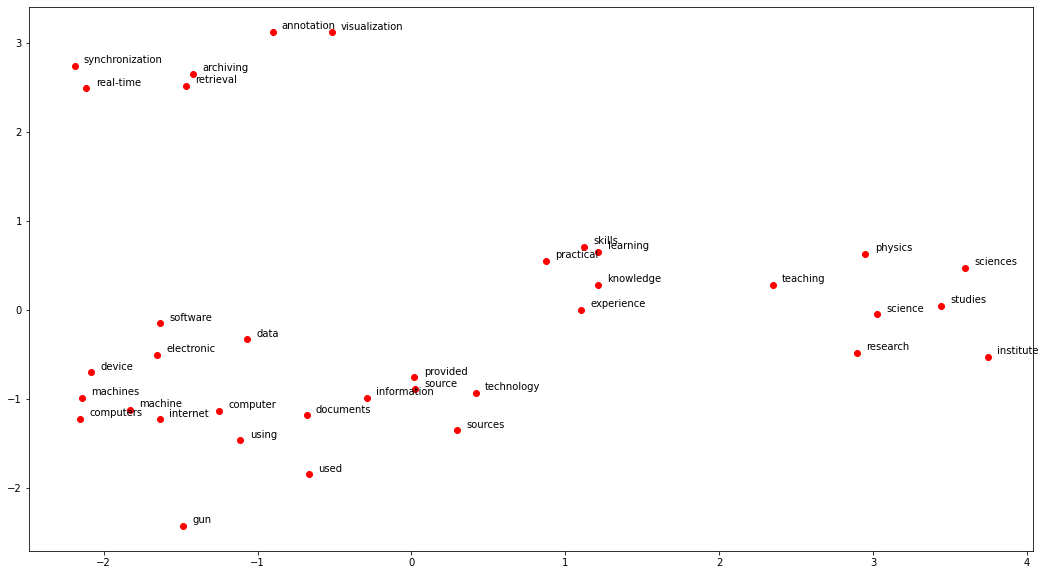

In [98]:
import matplotlib.pyplot as plt

word_vectors = wiki_model[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')